In [1]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.0.0
Build on:            	Jun 15 2015 15:17:27
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Simulated data:

In [96]:
data_N = 10
data_t = np.linspace(0.1,1,data_N)+0.005*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+np.pi/2.)+0.16*(np.random.rand(data_N)-0.5))

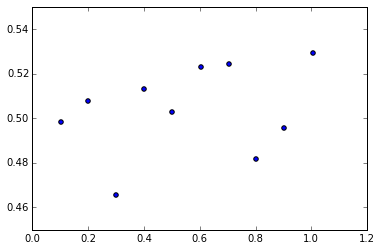

In [97]:
plt.scatter(data_t, data_rv);

## Setting up simulations

In [98]:
def simulation_rv(cart):
    r.reset()
    r.add(m=1.)
    r.add(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    ps = r.particles
    sim_rv = np.zeros(len(data_t))
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv[i] = ps[1].vx
    return sim_rv

def simulation(cart):
    r.reset()
    numvar = 4
    r.N_megnopp = numvar # 4 variation equations per particle
    r.add(m=1.)
    op = r.Particle(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    
    r.add(op)
    N = r.N
    
    r.init_megno(0.)
    ps = r.particles
    
    
    delta = 1e-4
    # First order
    for l in range(numvar):
        cart2 = cart.copy()
        cart2[l] += delta
        mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])

        vari = N*l+1+N
        ps[vari].x  = (mp.x  - ps[1].x  )
        ps[vari].y  = (mp.y  - ps[1].y  )
        ps[vari].z  = (mp.z  - ps[1].z  )
        ps[vari].vx = (mp.vx - ps[1].vx )
        ps[vari].vy = (mp.vy - ps[1].vy )
        ps[vari].vz = (mp.vz - ps[1].vz )
        
    _id = 0
    # Second order
    for l in range(numvar):
        for k in range(l+1):
            cart2 = cart.copy()
            cart2[l] += delta
            mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] -= delta
            mm = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
            
            vari = N*_id+1+N+numvar*N
            ps[vari].x  = 1.*(mp.x  - 2.*ps[1].x  + mm.x )
            ps[vari].y  = 1.*(mp.y  - 2.*ps[1].y  + mm.y )
            ps[vari].z  = 1.*(mp.z  - 2.*ps[1].z  + mm.z )
            ps[vari].vx = 1.*(mp.vx - 2.*ps[1].vx + mm.vx)
            ps[vari].vy = 1.*(mp.vy - 2.*ps[1].vy + mm.vy)
            ps[vari].vz = 1.*(mp.vz - 2.*ps[1].vz + mm.vz)
            #if _id ==0:
            #    print ps[vari].vx,ps[vari].vy
            _id +=1
    
     
    sim_rv = 0.
    sim_rvd = np.zeros(numvar)
    sim_rvd2 = np.zeros((numvar*(numvar+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[1].vx-data_rv[i]
        sim_rv  += dv**2
        for k in range(numvar):
            idvar2 = (k*(k+1)/2+k)*N+N*numvar+N+1
            sim_rvd[k] += 2.*(2.*ps[idvar2].vx+ps[k*N+1+N].vx)*(dv+ps[k*N+1+N].vx+ps[idvar2].vx)
        _id = 0
        for l in range(numvar):
            for k in range(l+1):
                idvar2 = _id*N+N*numvar+N+1

                sim_rvd2[_id][0] += 2.*ps[idvar2].vx*(dv+ps[k*N+1+N].vx+0.5*ps[idvar2].vx) + 2.*(ps[k*N+1+N].vx+ps[idvar2].vx)**2
                sim_rvd2[_id][1] += 2.*(ps[idvar2].vx+ps[k*N+1+N].vx)*(dv+ps[k*N+1+N].vx+0.5*ps[idvar2].vx)

                #(ps[k*N+1+N].vx)**2 + 2.*dv*ps[idvar2].vx + 6.*ps[idvar2].vx*ps[l*N+1+N].vx + 3.*(ps[idvar2].vx)**2
                 
                #if _id ==0 and i == len(data_t)-1:
                #    print ps[1].vx,ps[l*N+N+1].vx,ps[vari].vx
                _id += 1
    err  = np.sqrt(sim_rv)
    errd = sim_rvd/(2.*delta*err)

    #err = sim_rv
    #errd = sim_rvd
    #errd2 = sim_rvd2
    
    errd2m = np.zeros((numvar,numvar))
    _id = 0
    for l in range(numvar):
        for k in range(l+1):
            fdd =   sim_rvd2[_id][0]/(2.*(delta**2)*err) - (sim_rvd2[_id][1])**2/(4.*(delta**2)*(err**3))
            #fdd =   (errd2[_id][0] -  errd2[_id][3])
            #if _id==0:
            #    print fdd, errd[0,0]-errd[0,1]
            #print fdd, err
            errd2m[l,k] = fdd
            errd2m[k,l] = fdd
            _id +=1
    
    #print err, -(errd-err)/delta, -(errd2-err)/(delta)
    
    return err, errd, errd2m

## Visual Check

In [99]:
gamma = 0.05
a0 = np.array([4.5,0.1,0.,-np.pi/2.]) # initial parameters
a = a0.copy()
sim_rvs = []             # for plotting

lastp = 1e200
lasta = a
lastgradient = []

sim_rv0 = simulation_rv(a)

N_grid = 150
a_s = np.linspace(4.0,8.0,N_grid)

errs = np.zeros(N_grid)
gradients = np.zeros(N_grid)
hessians = np.zeros(N_grid)

for i,at in enumerate(a_s):
    a[0] = at
    err, gradient, hessian = simulation(a)
    #print gradient[0], hessian[0,0]
    # print hessian
    errs[i] = err
    gradients[i] = gradient[0]
    hessians[i] = hessian[0,0]
    

        

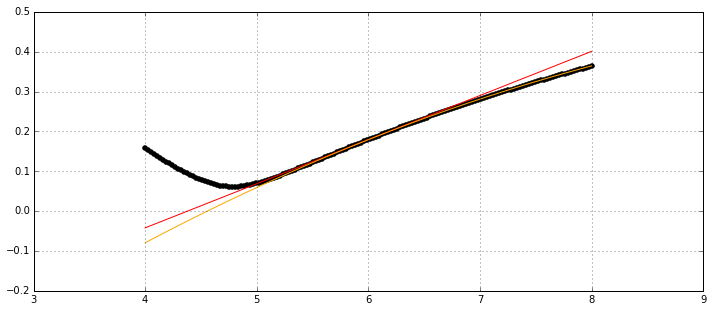

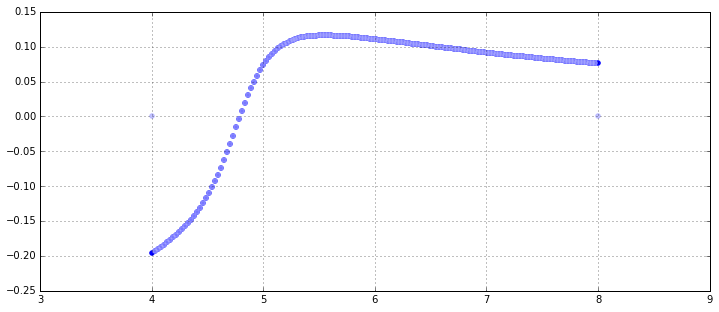

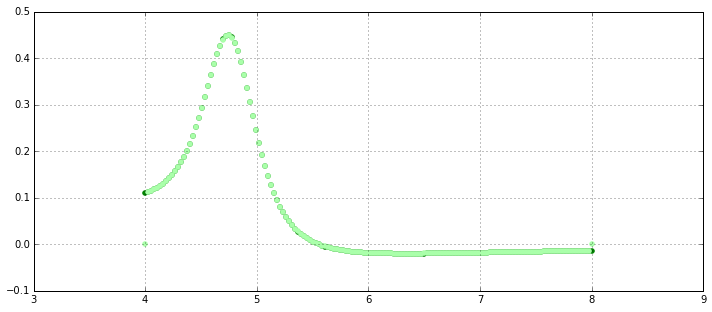

In [102]:
def widget_plot(ind):
    ind = int(ind)
    fig = plt.figure(figsize=(12,5))
    plt.scatter(a_s, errs, color="k");
    
    def f(a,i):
        da = a - a_s[i] 
        return errs[i] + gradients[i]*da,  errs[i] + gradients[i]*da + 0.5*hessians[i]*da*da
    
    a_s_fine = np.linspace(a_s[0],a_s[-1],N_grid*10)
    err_fine = np.zeros(N_grid*10)
    err_fine2 = np.zeros(N_grid*10)
    for i,a in enumerate(a_s_fine):
        err_fine[i], err_fine2[i] = f(a,ind)
    plt.plot(a_s_fine, err_fine, color="r");
    plt.plot(a_s_fine, err_fine2, color="#FFA500");
    plt.grid()


    
    gradient_direct = np.zeros(N_grid)
    hessian_direct = np.zeros(N_grid)
    for i,a in enumerate(a_s_fine):
        if i>0 and i<N_grid-1:
            gradient_direct[i] = (errs[i+1]-errs[i-1])/(a_s[i+1]-a_s[i-1])
            hessian_direct[i]  = (errs[i+1]-2.*errs[i]+errs[i-1])/((a_s[i+1]-a_s[i])*(a_s[i]-a_s[i-1]))
            
    fig2 = plt.figure(figsize=(12,5))
    plt.scatter(a_s, gradients, color="b");
    plt.scatter(a_s, gradient_direct, color="#aaaaff",alpha=0.7);
    plt.grid()

    
    fig3 = plt.figure(figsize=(12,5))
    #plt.ylim([-.02,.02])
    plt.scatter(a_s, hessians, color="g");
    plt.scatter(a_s, hessian_direct, color="#aaffaa");
    plt.grid()


    

    return fig, fig2, fig3


w = interactive(widget_plot,
                ind=(0,N_grid))

display(w)

In [92]:
hessians

array([ 0.02585589,  0.02542851,  0.02501099,  0.02460297,  0.02420426,
        0.02381451,  0.02343348,  0.02306093,  0.02269667,  0.02234039,
        0.0219919 ,  0.021651  ,  0.02131746,  0.02099108,  0.02067168,
        0.02035905,  0.02005302,  0.01975346,  0.0194601 ,  0.01917286,
        0.01889152,  0.01861598,  0.01834607,  0.01808167,  0.01782259,
        0.01756874,  0.01732   ,  0.0170762 ,  0.01683729,  0.01660306,
        0.01637348,  0.01614841,  0.01592776,  0.01571144,  0.01549933,
        0.01529138,  0.01508751,  0.01488761,  0.01469163,  0.01449953,
        0.01431125,  0.01412675,  0.01394602,  0.01376904,  0.0135958 ,
        0.01342641,  0.01326091,  0.01309946,  0.01294226,  0.01278966,
        0.01264214,  0.0125005 ,  0.01236586,  0.01224012,  0.01212634,
        0.01202986,  0.01196054,  0.01193823,  0.01200805,  0.01229131,
        0.0132154 ,  0.01728698,  0.10340922, -0.03745349, -0.01469519,
       -0.01204485, -0.0111715 , -0.01073223, -0.01045008, -0.01

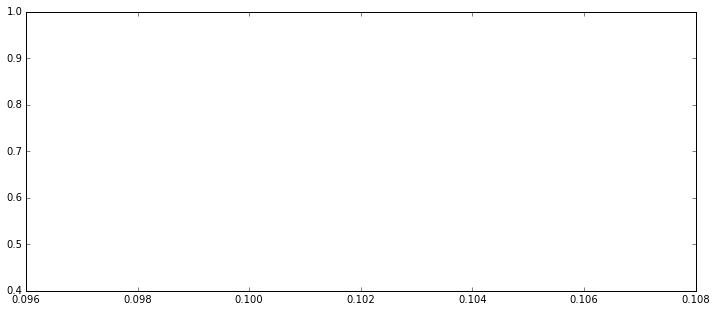

In [81]:
sim_rv = simulation_rv(a0)
fig = plt.figure(figsize=(12,5))  

plt.plot(data_t,data_rv, color="r");
plt.plot(data_t,sim_rv, color="b");

